In [1]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy

print (sys.version)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


In [2]:
#setup
#tau: conformal time, a: scale factor, k: wavenumber (comoving)
#using natural units, hbar = c = 1, working in mpc

#constants
c = 3 * 1e8
h_0 = 0.7 
H_0 = h_0 * (1e5 / c) #maggiore, eq 17.5. units: mpc^-1

Omega_R = 4.184 * 1e-5 * (h_0 ** -2) #maggiore 17.79
Omega_M = 0.3 #maggiore 17.80
Omega_L = 1 - Omega_R - Omega_M #see section below maggiore 17.80
# Lambda = (1 / 3.24078) * 1e-6 #from wikipedia (converted), units: mpc^-2

#RD/MD equilibrium, maggiore values
a_eq = Omega_R / Omega_M #maggiore 17.83
tau_0 = 0.879 * 2 / (H_0 * math.sqrt(Omega_M))
tau_star = (2 * math.sqrt(Omega_R)) / (H_0 * Omega_M)
tau_eq = (math.sqrt(2) - 1) * tau_star
tau_dec = 2.55

k_eq = 0.073 * Omega_M * h_0**2 #from papers

#MD/lambdaD equilibrium (?)
a_eq2 = (Omega_M / Omega_L) ** (1/3)

#from mukoyama BT mg paper
# H_inf = gev_to_mpci(1e8)
# m_g1 = 0.5 * H_inf #or 0.8

m_g = 1e9 * H_0 #from emir, m < 1e-5 Hz
# m_g2 = gev_to_mpci(7.6e-29)
print(m_g)

tau_off = tau_eq * (1/2) #chosen somewhat arbitrarily
# print(m_g1, m_g2)



233333.3333333333


In [3]:

#functions
def gev_to_mpci(gev):
    return gev * 1.5626 * 1e38
def hz_to_mpci(hz):
    return hz * 1.0286 * 1e14
def hzi_to_mpc(hzi):
    return hzi / (1.0286 * 1e14)

def a_RD_deep(tau): #deep in RD, maggiore 17.130
    return H_0 * math.sqrt(Omega_R) * tau
def a_MD_deep(tau): #deep in MD, maggiore 17.143
    return (1 / 4) * (H_0 ** 2) * Omega_M * (tau ** 2)

#stitches above two functions, not great
def a_RDMD_deep(tau):
    if tau < tau_eq:
        return a_RD_deep(tau)
    else:
        return a_MD_deep(tau)

def a_RDMD(tau): #RD and MD, maggiore 17.152
    return a_eq * ((2 * tau / tau_star) + (tau / tau_star)**2 )

def a_RDMD_p(tau):
    return a_eq * ((2 / tau_star) + (2 * tau / (tau_star ** 2)))

def curly_H(tau):
    return a_RDMD_p(tau) / a_RDMD(tau)

def normal_H(tau):
    return a_RDMD_p(tau) / (a_RDMD(tau)**2)

# graviton mass (time-dependent, use later)
def m_gr(tau):
    if tau < tau_off:
        return m_g
    else:
        return 0
    
# def omega(k, tau):
#     return np.sqrt((k**2 / a_RDMD(tau)**2) + m_g**2)
    


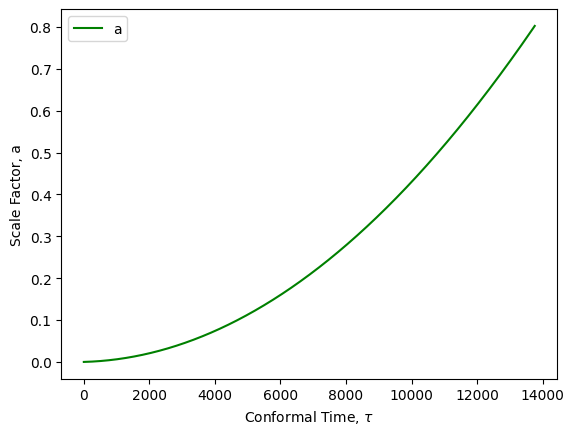

In [4]:
#plotting scale factor

tau_domain = np.linspace(1, tau_0, 10000)

a = (np.vectorize(a_RDMD))(tau_domain)
# cH = (np.vectorize(curly_H))(tau_domain)

#derivative test:
# a = np.vectorize(a_turner)(tau_domain)
# H_num = (np.gradient(a, tau_domain)) / (a)

plt.plot(tau_domain, a, c = "g", label = "a")
# plt.plot(tau_domain, H, c = "b")
# plt.axvline(tau_eq, color = "black", linestyle = "dashed", label = "RD-MD Equality")

# plt.axvline(tau_0, color = "black", linestyle = "dashed")

plt.xlabel(r"Conformal Time, $\tau$")
plt.ylabel(r"Scale Factor, a")
plt.legend()


In [5]:
#horizon crossing calculations

#use this for GR
def GR_hc_H(k): #calc h.c. time for k using curlyH = k
    eq = lambda tau: curly_H(tau) - k
    return scipy.optimize.fsolve(eq, 0.001)[0]
def GR_hc_H_inv(tau): #calc. k s.t. h.c. time for k is tau
    return curly_H(tau)

# #use this for MG
# def MG_hc_H(k): #calc h.c. time for k using H^2 = (k/a)^2 + m_g^2
#     eq = lambda tau: normal_H(tau) - omega(k, tau)
#     return scipy.optimize.fsolve(eq, 0.001)[0]

# def hc_tau(k): #calc h.c. time for k using k*tau = 1
#     return (1 / k)

#calculate k_c
# eqk = lambda tau: normal_H(tau) - (math.sqrt(2) * m_gr(tau))
# tau_c = scipy.optimize.fsolve(eqk, 0.001)[0]
# k_c = a_RDMD(tau_c) * m_g
# k_c2 = (a_RDMD(tau_c) * normal_H(tau_c)) / math.sqrt(2) #same as above
# k_0 = a_RDMD(tau_0) * m_g
# print(tau_c)



In [6]:
#calculating transfer function
def GR_transfer_exp(choice, sc, k):
    bessel_part = (3 * scipy.special.spherical_jn(1, (k * sc) * tau_0) / ((k * sc) * tau_0))
    approx_part = math.sqrt(1 + 1.36*(k / k_eq) + 2.5*((k / k_eq)**2))
    if choice == 'full':
        return bessel_part * approx_part
    else:
        return bessel_part if choice == 'bessel' else approx_part

def BTTS_fit(k):
    return math.sqrt(1 + 1.57*(k / k_eq) + 3.42*((k / k_eq)**2))

#helper for solve_ivp, specific to massless diff. eq.
def GR_derivs(k): #pass in k to use
    def wrapper(tau, y):
        a = y[0]
        b = y[1]
        return [b, -2 * curly_H(tau) * b - a * (k**2)]
    return wrapper

def GR_transfer_num(k):
    taus = np.linspace(0.0001, tau_0, 2) #only need 2 points technically lol
    #GR derivs given above, y0 has 1 for init h_k and 0 for h_k'
    sols = scipy.integrate.solve_ivp(GR_derivs(k), t_span = [taus[0], taus[-1]], y0 = [1, 0], t_eval = taus)
    return sols.y[0][-1] 

def GR_transfer_num_WKB(k):
    tau_k = GR_hc_H(k)
    # return 1 if (tau_k > tau_0) else a_RDMD(tau_k) / a_RDMD(tau_0)
    return 1 if (tau_k > tau_0) else a_RDMD(tau_k)
    # eq = lambda tau: np.sqrt((omega(k, tau_k) * (a_RDMD(tau_k)**3)) / (omega(k, tau) * (a_RDMD(tau) ** 3))) 
    # eq = lambda tau: a_RDMD(tau_k) / a_RDMD(tau)
    # return 1 if (tau_k > tau_0) else eq(tau_0)


#helper for solve_ivp, specific to massive diff. eq.
def MG_derivs(k): #pass in k to use
    def wrapper(tau, y):
        a = y[0]
        b = y[1]
        return [b, -2 * curly_H(tau) * b - a * (k**2 + (m_gr(tau) * a_RDMD(tau))**2)]
    return wrapper

def MG_transfer_num(k):
    taus = np.linspace(0.0001, tau_0, 2) #only need 2 points technically lol
    #MG derivs given above, y0 has 1 for init h_k and 0 for h_k'
    sols = scipy.integrate.solve_ivp(MG_derivs(k), t_span = [taus[0], taus[-1]], y0 = [1, 0], t_eval = taus)
    return sols.y[0][-1] 

# def MG_transfer_num_WKB(k):
#     tau_k = MG_hc_H(k)
#     eq = lambda tau: np.sqrt((omega(k, tau_k) * (a_RDMD(tau_k)**3)) / (omega(k, tau) * (a_RDMD(tau) ** 3))) 
#     return 1 if (tau_k > tau_0) else eq(tau_0)

#plotting evolution of h_k
def GR_evol(k, tau_dom):
    sols = scipy.integrate.solve_ivp(GR_derivs(k), t_span = [tau_dom[0], tau_dom[-1]], y0 = [1, 0], t_eval = tau_dom)
    return sols.y[0]

def GR_WKB(k, tau_dom):
    tau_k = GR_hc_H(k)
    eq = lambda tau: a_RDMD(tau_k) / a_RDMD(tau) #for GR, ie. m_g = 0
    m = map(lambda tau: 1 if tau < tau_k else eq(tau), tau_dom)
    return np.array(list(m))

def MG_evol(k, tau_dom):
    sols = scipy.integrate.solve_ivp(MG_derivs(k), t_span = [tau_dom[0], tau_dom[-1]], y0 = [1, 0], t_eval = tau_dom)
    return sols.y[0]

# def MG_WKB(k, tau_dom):
#     tau_k = MG_hc_H(k)
#     eq = lambda tau: np.sqrt((omega(k, tau_k) * (a_RDMD(tau_k)**3)) / (omega(k, tau) * (a_RDMD(tau) ** 3))) 
#     m = map(lambda tau: 1 if tau < tau_k else eq(tau), tau_dom)
#     return np.array(list(m))

0.0010730999999999998


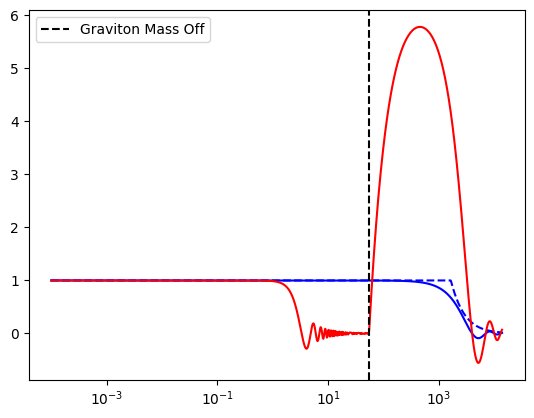

In [7]:
#plotting h_k for GR and MG
k_try = k_eq * 0.1
print(k_try)
# tau_domain = np.linspace(0.0001, tau_0, 10000)
tau_domain = np.logspace(-4, np.log10(tau_0), 1000)

GR_evol_k = GR_evol(k_try, tau_domain)
GR_WKB_k = GR_WKB(k_try, tau_domain)
MG_evol_k = MG_evol(k_try, tau_domain)
# MG_WKB_k = MG_WKB(k_try, tau_domain)

plt.semilogx(tau_domain, GR_evol_k, "b")
plt.semilogx(tau_domain, GR_WKB_k, "b--")
plt.semilogx(tau_domain, MG_evol_k, "r")
# plt.plot(tau_domain, MG_WKB_k, "r--")

# plt.axvline(tau_eq, color = "black", linestyle = "dashed", label = "RD-MD Equality")
plt.axvline(tau_off, color = "black", linestyle = "dashed", label = "Graviton Mass Off")
plt.legend()


In [8]:
print(GR_evol_k[-1], GR_transfer_num(k_try))
print(MG_evol_k[-1], MG_transfer_num(k_try))

0.011223694599970498 0.011223694599970533
0.06956815836603981 0.06956815836604008


In [29]:
print(GR_hc_H_inv(tau_0), k_eq)

0.00014270725323580144 0.010730999999999997


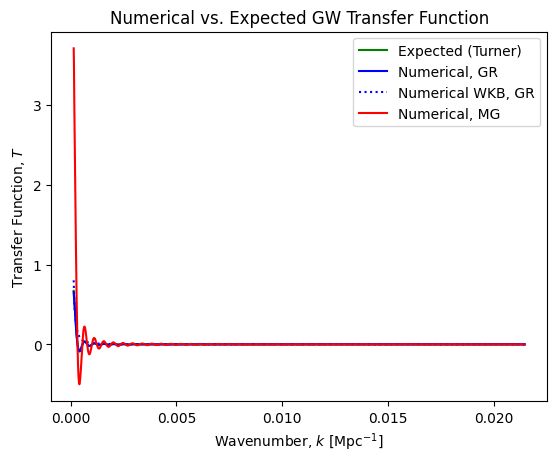

In [37]:
#plotting transfer function, numerical and expected

# k_dom = np.linspace(GR_hc_H_inv(tau_0), k_eq, 1000) #full region of interest

#region selector
num_regions = 1
#choose: 1, ..., num_regions
curr_region = 1

region_size = (k_eq - GR_hc_H_inv(tau_0)) / num_regions
start_k = GR_hc_H_inv(tau_0) + (region_size * (curr_region - 1))
end_k = GR_hc_H_inv(tau_0) + (region_size * (curr_region))

# k_dom = np.linspace(start_k, end_k, 1200)
# k_dom = np.linspace(k_eq, k_c, 1000)
k_dom = np.linspace(GR_hc_H_inv(tau_0), k_eq * 2, 2000)


#evaluation

#turner expected
# tr_exp_b = (np.vectorize(GR_transfer_exp))("bessel", 1, k_dom)
GR_tr_exp_nb = (np.vectorize(GR_transfer_exp))("no bessel", 1, k_dom)
GR_tr_exp = (np.vectorize(GR_transfer_exp))("full", 1, k_dom)
# blue tilted tensor spectrum paper expected (no bessel)
GR_tr_BTTS_fit = (np.vectorize(BTTS_fit))(k_dom)

#numerical, GR
GR_tr_num = (np.vectorize(GR_transfer_num))(k_dom)
GR_tr_num_WKB = (np.vectorize(GR_transfer_num_WKB))(k_dom)
#numerical, MG
MG_tr_num = (np.vectorize(MG_transfer_num))(k_dom)
# MG_tr_num_WKB = (np.vectorize(MG_transfer_num_WKB))(k_dom)

#plot transfer function curves
plt.plot(k_dom, GR_tr_exp, "g", label = "Expected (Turner)", zorder = 0)
# plt.plot(k_dom, tr_exp_b, c = "g", label = "exp, bessel")
# plt.plot(k_dom, tr_exp_nb, c = "b", label = "exp, no bessel")
plt.plot(k_dom, GR_tr_num, "b", label = "Numerical, GR", zorder = 0)
plt.plot(k_dom, GR_tr_num_WKB, "b:", label = "Numerical WKB, GR", zorder = 0)

plt.plot(k_dom, MG_tr_num, "r", label = "Numerical, MG", zorder = 0)

#turn these off for other ranges
# plt.axvline(k_eq, color = "black", linestyle = "dashed", label = r"$k_\mathrm{eq}$")
# plt.axvline(GR_hc_H_inv(tau_0), color = "black", linestyle = "dotted", label = r"$k_0$")

plt.xlabel(r"Wavenumber, $k$ $[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"Transfer Function, $T$")
plt.title("Numerical vs. Expected GW Transfer Function")

plt.legend()

In [31]:
#given k array and vals array, calculate mins and maxes
#return two arrays: one for ks, one of max/min vals
# def extrema(ks, vals):
#     k_e = []
#     val_e = []
#     lev = 10
#     for i in range(lev, len(vals)-lev):
#         if (vals[i] > vals[i-1] and vals[i] > vals[i+1] and vals[i] > vals[i-lev] and vals[i] > vals[i+lev] ) or \
#            (vals[i] < vals[i-1] and vals[i] < vals[i+1] and vals[i] < vals[i-lev] and vals[i] < vals[i+lev]):
#             k_e.append(ks[i])
#             val_e.append(vals[i])
#     return (k_e, val_e)

def extrema(ks, vals):
    lev = 10
    maxes = scipy.signal.argrelextrema(vals, np.greater, order = lev)
    mins = scipy.signal.argrelextrema(vals, np.less, order = lev)
    ind = np.sort(np.concatenate([maxes[0], mins[0]]))
    return (np.vectorize(lambda i: ks[i])(ind), np.vectorize(lambda i: vals[i])(ind))

    

92 93 93


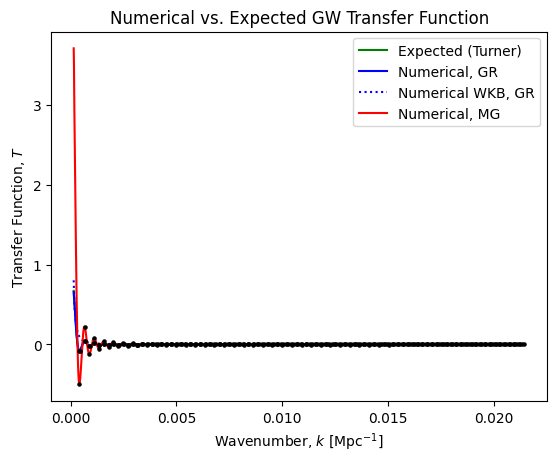

In [38]:
#post processing plots [-100:]
start = 0
pts = 2000

#calc and plot extrema points
(GR_k_ext_num, GR_tr_ext_num) = extrema(k_dom[start:(start + pts)], GR_tr_num[start:(start + pts)])
plt.scatter(GR_k_ext_num, GR_tr_ext_num, c = "k", s = 5, zorder = 1)

(GR_k_ext_exp, GR_tr_ext_exp) = extrema(k_dom[start:(start + pts)], GR_tr_exp[start:(start + pts)])
plt.scatter(GR_k_ext_exp, GR_tr_ext_exp, c = "k", s = 5, zorder = 1)

(MG_k_ext_num, MG_tr_ext_num) = extrema(k_dom[start:(start + pts)], MG_tr_num[start:(start + pts)])
plt.scatter(MG_k_ext_num, MG_tr_ext_num, c = "k", s = 5, zorder = 1)

#plot transfer function curves
plt.plot(k_dom[start:(start + pts)], GR_tr_exp[start:(start + pts)], c = "g", label = "Expected (Turner)", zorder = 0)
# plt.plot(k_dom, tr_exp_b, c = "g", label = "exp, bessel")
# plt.plot(k_dom, tr_exp_nb, c = "b", label = "exp, no bessel")
plt.plot(k_dom[start:(start + pts)], GR_tr_num[start:(start + pts)], c = "b", label = "Numerical, GR", zorder = 0)
plt.plot(k_dom[start:(start + pts)], GR_tr_num_WKB[start:(start + pts)], "b:", label = "Numerical WKB, GR", zorder = 0)

plt.plot(k_dom[start:(start + pts)], MG_tr_num[start:(start + pts)], c = "r", label = "Numerical, MG", zorder = 0)

#turn these off for other ranges
# plt.axvline(k_eq, color = "black", linestyle = "dashed", label = r"$k_\mathrm{eq}$")
# plt.axvline(GR_hc_H_inv(tau_0), color = "black", linestyle = "dotted", label = r"$k_0$")

plt.xlabel(r"Wavenumber, $k$ $[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"Transfer Function, $T$")
plt.title("Numerical vs. Expected GW Transfer Function")

plt.legend()

print(len(GR_tr_ext_exp), len(GR_tr_ext_num), len(MG_tr_ext_num))

In [39]:
GR_tr_exp_nb = (np.vectorize(GR_transfer_exp))("no bessel", 1, k_dom)
GR_tr_BTTS_fit = (np.vectorize(BTTS_fit))(k_dom)

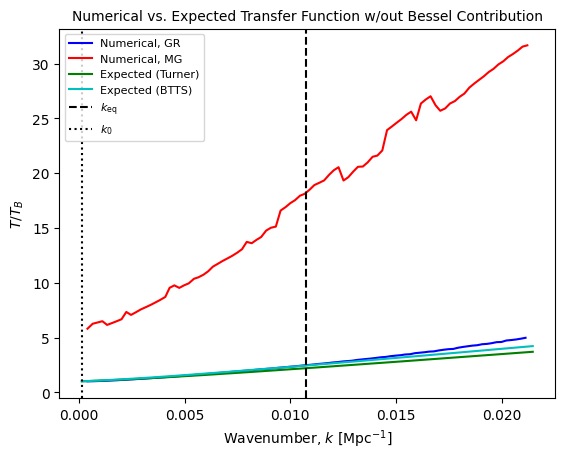

In [43]:
#take min in case there are false positives in extrema
min_len = min(len(GR_tr_ext_num), len(GR_tr_ext_exp), len(MG_tr_ext_num))

#divide out bessel part, point by point on extrema
GR_tr_ext_num_nb = []
for i in range(min_len):
    k_curr = GR_k_ext_exp[i] #corresponding k value in exp
    bes = (3 * scipy.special.spherical_jn(1, (k_curr) * tau_0) / ((k_curr) * tau_0)) #bessel part
    # print(tr_ext_num[i], bes)
    GR_tr_ext_num_nb.append(GR_tr_ext_num[i] / bes)
    
MG_tr_ext_num_nb = []
for i in range(min_len):
    k_curr = GR_k_ext_exp[i] #corr k value in exp
    bes = (3 * scipy.special.spherical_jn(1, (k_curr) * tau_0) / ((k_curr) * tau_0)) #bessel part
    MG_tr_ext_num_nb.append(MG_tr_ext_num[i] / bes)

#plot transfer functions w/out bessel part
# plt.scatter(k_ext_num[:(min_len)], tr_ext_num_nb, c = "r", s = 5, zorder = 1, label = "num, nb")
plt.plot(GR_k_ext_num[:(min_len)], GR_tr_ext_num_nb, c = "b", zorder = 1, label = "Numerical, GR")
plt.plot(MG_k_ext_num[:(min_len)], MG_tr_ext_num_nb, c = "r", zorder = 1, label = "Numerical, MG")
# plt.scatter(k_ext_exp, tr_ext_exp_nb, c = "b", s = 5, zorder = 1, label = "exp, no bessel")

plt.plot(k_dom, GR_tr_exp_nb, c = "g", label = "Expected (Turner)")
plt.plot(k_dom, GR_tr_BTTS_fit, c = "c", label = "Expected (BTTS)")

#turn these off for other ranges
plt.axvline(k_eq, color = "black", linestyle = "dashed", label = r"$k_\mathrm{eq}$")
plt.axvline(GR_hc_H_inv(tau_0), color = "black", linestyle = "dotted", label = r"$k_0$")

plt.xlabel(r"Wavenumber, $k$ $[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$T / T_B$")
plt.title("Numerical vs. Expected Transfer Function w/out Bessel Contribution", fontsize = 10)

# plt.legend()
plt.legend(loc = 2, prop={'size': 8})

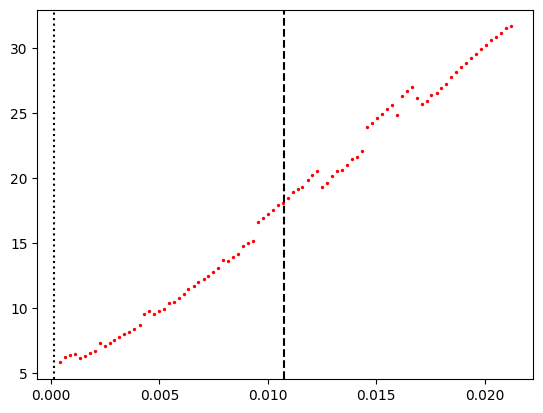

In [46]:
plt.scatter(MG_k_ext_num[:(min_len)], MG_tr_ext_num_nb, c = "r", zorder = 1, s = 2, label = "Numerical, MG")

#turn these off for other ranges
plt.axvline(k_eq, color = "black", linestyle = "dashed", label = r"$k_\mathrm{eq}$")
plt.axvline(GR_hc_H_inv(tau_0), color = "black", linestyle = "dotted", label = r"$k_0$")

In [ ]:
#slope calculation

slope = (MG_tr_ext_num_nb[-1] - MG_tr_ext_num_nb[-3]) / (MG_k_ext_num[-1] - MG_k_ext_num[-3])
print(slope * k_eq)